In [1]:
#
# Created on 4/15/2021
#
# @author Seyed Mostafa Mousavi Kahaki
#
# Email: mousavikahaki@gmail.com
#
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import segmentation_models as sm
import os, random, sys
import pandas as pd
import tqdm
# import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.losses import binary_crossentropy
from skimage.morphology import label

C:\Users\Seyed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Seyed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Seyed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Seyed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

Segmentation Models: using `keras` framework.


In [2]:
Backbone_model = 'resnet34'

IMG_HEIGHT = 128
IMG_WIDTH = 128
N_CHANEL = 3


TrainPath = '../Data/stage1_train/'
TestPath = '../Data/stage1_test/'

model_name = 'Unet_'+Backbone_model

In [3]:
def get_train_data(train_path):
    ids_train = next(os.walk(train_path))[1]
    n_train_img = len(ids_train)
    x_train = np.zeros((n_train_img, IMG_HEIGHT, IMG_WIDTH, N_CHANEL), dtype=np.uint8)
    y_train = np.zeros((n_train_img, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    # for i, idx in tqdm_notebook(enumerate(ids_train), total=len(ids_train)):
    for i, idx in enumerate(ids_train):
        im_path = train_path + idx
        im = imread(im_path + '/images/' + idx + '.png')[:, :, :N_CHANEL]
        im = resize(im, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        x_train[i] = im

        label_max = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        ids_labels = next(os.walk(im_path + '/masks/'))[2]
        for label_file in ids_labels:
            label = imread(im_path + '/masks/' + label_file)
            label = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            label = np.expand_dims(label, axis=-1)
            label_max = np.maximum(label_max, label)

        y_train[i] = label_max

    return x_train, y_train

In [4]:
def get_test_data(test_path):
    ids_test = next(os.walk(test_path))[1]
    n_test_img = len(ids_test)
    x_test = np.zeros((n_test_img, IMG_HEIGHT, IMG_WIDTH, N_CHANEL), dtype=np.uint8)

    sizes_test = []
    # for i, idx in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    for i, idx in enumerate(ids_test):
        im_path = test_path + idx
        im = imread(im_path + '/images/' + idx + '.png')
        im = resize(im, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
        sizes_test.append([im.shape[0], im.shape[1]])
        x_test[i] = im[:, :, :N_CHANEL]

    return x_test, sizes_test

In [5]:
def visualize_random_train(x,y):
    # Visualize Random Train Data
    ix = random.randint(0, len(x))
    has_mask = y[ix].max() > 0  # salt indicator

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

    ax1.imshow(x[ix, ..., 0], cmap='gray', interpolation='bilinear')
    if has_mask:  # if salt
        # draw a boundary(contour) in the original image separating salt and non-salt areas
        ax1.contour(y[ix].squeeze(), colors='c', linewidths=5, levels=[0.5])
    ax1.set_title('Original')

    ax2.imshow(y[ix].squeeze(), cmap='gray', interpolation='bilinear')
    ax2.set_title('Label')

In [6]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [7]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [8]:
def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [9]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[0].set_title('Original')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Label')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[3].set_title('Predicted binary');

In [10]:
X_train, Y_train = get_train_data(TrainPath)

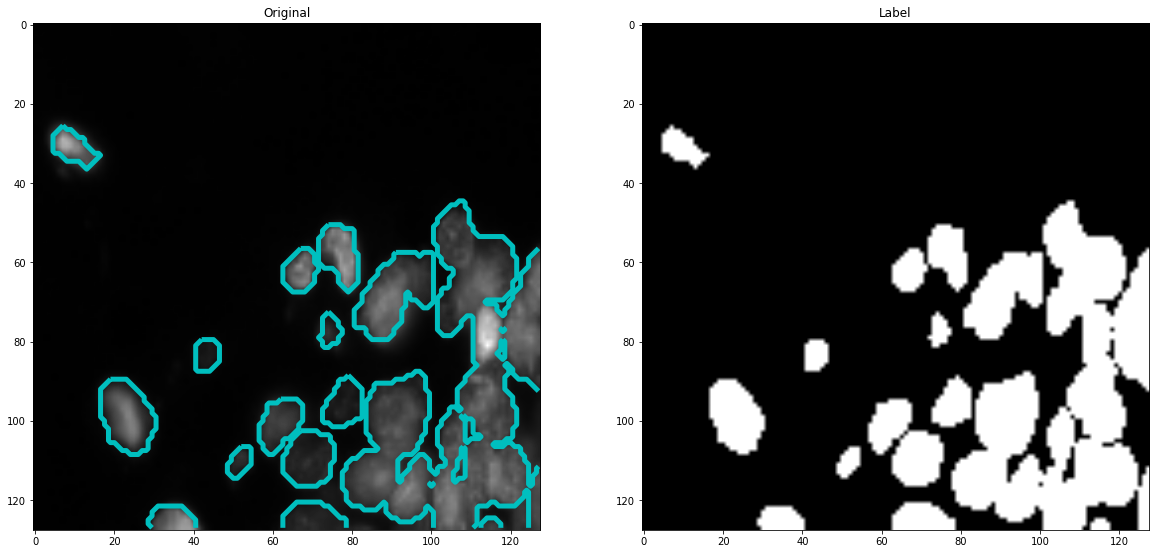

In [11]:
visualize_random_train(X_train,Y_train)

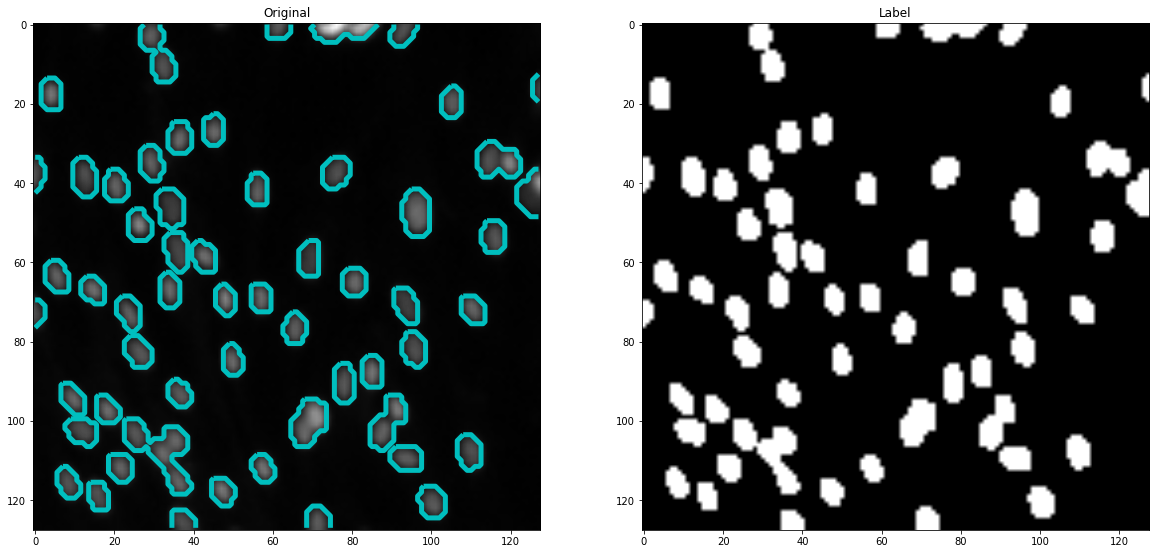

In [12]:
visualize_random_train(X_train,Y_train)

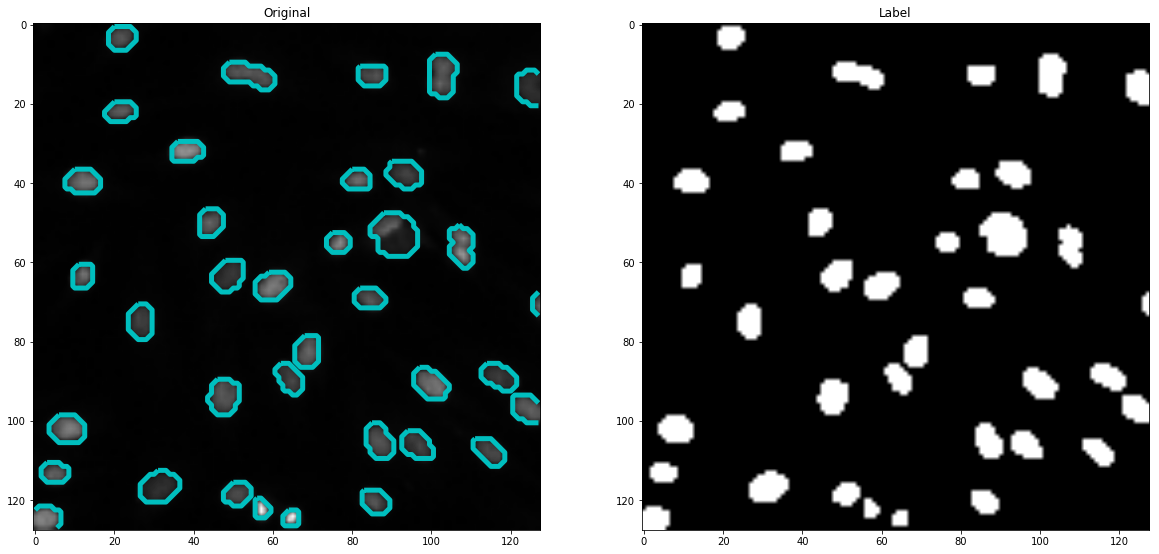

In [13]:
visualize_random_train(X_train,Y_train)

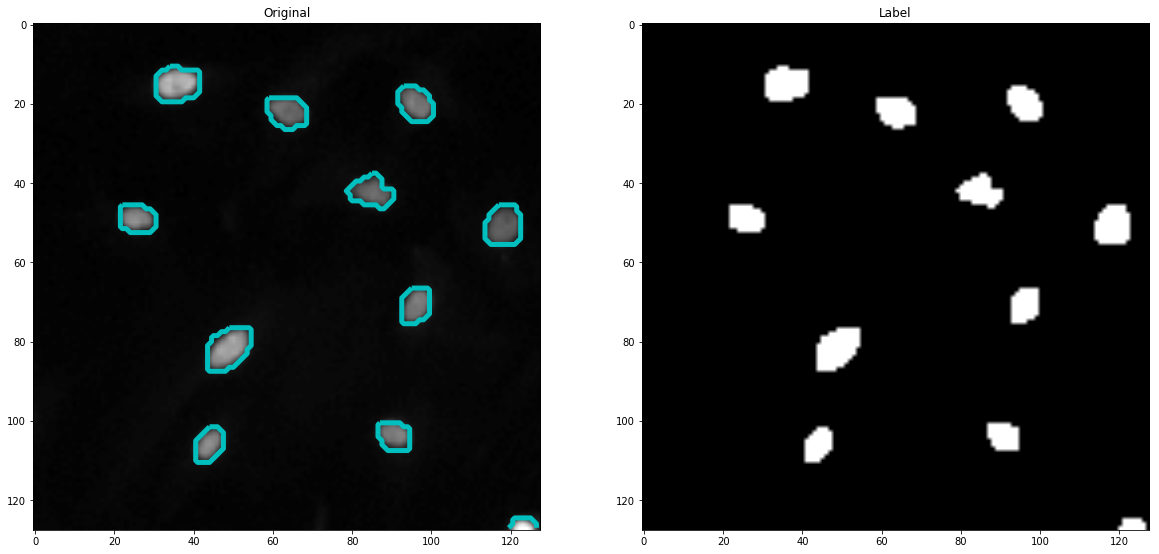

In [14]:
visualize_random_train(X_train,Y_train)

In [15]:
# Pre_process images
pre_process_fn = sm.get_preprocessing(Backbone_model)
X_train = pre_process_fn(X_train)

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [17]:
model = sm.Unet(Backbone_model,encoder_weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
model.compile(optimizer='adam',loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

In [19]:
print(model.summary())
# plot_model(model, to_file=model_name+'.png', show_shapes=True, show_layer_names=True)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

zero_padding2d_9 (ZeroPadding2D (None, None, None, 6 0           stage2_unit1_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit1_conv1 (Conv2D)     (None, None, None, 1 73728       zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
stage2_unit1_bn2 (BatchNormaliz (None, None, None, 1 512         stage2_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit1_relu2 (Activation) (None, None, None, 1 0           stage2_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, None, None, 1 0           stage2_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage2_uni

stage3_unit1_bn2 (BatchNormaliz (None, None, None, 2 1024        stage3_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit1_relu2 (Activation) (None, None, None, 2 0           stage3_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, None, None, 2 0           stage3_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit1_conv2 (Conv2D)     (None, None, None, 2 589824      zero_padding2d_18[0][0]          
__________________________________________________________________________________________________
stage3_unit1_sc (Conv2D)        (None, None, None, 2 32768       stage3_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_8 (Add

zero_padding2d_26 (ZeroPadding2 (None, None, None, 2 0           stage3_unit5_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit5_conv2 (Conv2D)     (None, None, None, 2 589824      zero_padding2d_26[0][0]          
__________________________________________________________________________________________________
add_12 (Add)                    (None, None, None, 2 0           stage3_unit5_conv2[0][0]         
                                                                 add_11[0][0]                     
__________________________________________________________________________________________________
stage3_unit6_bn1 (BatchNormaliz (None, None, None, 2 1024        add_12[0][0]                     
__________________________________________________________________________________________________
stage3_unit6_relu1 (Activation) (None, None, None, 2 0           stage3_unit6_bn1[0][0]           
__________

add_16 (Add)                    (None, None, None, 5 0           stage4_unit3_conv2[0][0]         
                                                                 add_15[0][0]                     
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, None, None, 5 2048        add_16[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, None, None, 5 0           bn1[0][0]                        
__________________________________________________________________________________________________
decoder_stage0_upsampling (UpSa (None, None, None, 5 0           relu1[0][0]                      
__________________________________________________________________________________________________
decoder_stage0_concat (Concaten (None, None, None, 7 0           decoder_stage0_upsampling[0][0]  
          

__________________________________________________________________________________________________
decoder_stage4b_conv (Conv2D)   (None, None, None, 1 2304        decoder_stage4a_relu[0][0]       
__________________________________________________________________________________________________
decoder_stage4b_bn (BatchNormal (None, None, None, 1 64          decoder_stage4b_conv[0][0]       
__________________________________________________________________________________________________
decoder_stage4b_relu (Activatio (None, None, None, 1 0           decoder_stage4b_bn[0][0]         
__________________________________________________________________________________________________
final_conv (Conv2D)             (None, None, None, 1 145         decoder_stage4b_relu[0][0]       
__________________________________________________________________________________________________
sigmoid (Activation)            (None, None, None, 1 0           final_conv[0][0]                 
Total para

In [20]:
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

In [21]:
history = model.fit(X_train,
                    Y_train,
                    batch_size=2,
                    epochs=300,
                    verbose=2,
                    validation_data=(X_val,Y_val))

Instructions for updating:
Use tf.cast instead.
Train on 536 samples, validate on 134 samples
Epoch 1/300
 - 107s - loss: 0.7285 - iou_score: 0.5075 - val_loss: 1.0916 - val_iou_score: 0.4017
Epoch 2/300
 - 94s - loss: 0.4915 - iou_score: 0.6687 - val_loss: 0.6399 - val_iou_score: 0.5971
Epoch 3/300
 - 93s - loss: 0.4213 - iou_score: 0.7172 - val_loss: 3.1537 - val_iou_score: 0.0773
Epoch 4/300
 - 93s - loss: 0.4099 - iou_score: 0.7267 - val_loss: 0.8495 - val_iou_score: 0.4627
Epoch 5/300
 - 96s - loss: 0.3692 - iou_score: 0.7491 - val_loss: 1.5425 - val_iou_score: 0.4255
Epoch 6/300
 - 97s - loss: 0.3435 - iou_score: 0.7656 - val_loss: 1.0018 - val_iou_score: 0.5072
Epoch 7/300
 - 101s - loss: 0.3296 - iou_score: 0.7784 - val_loss: 0.7196 - val_iou_score: 0.5708
Epoch 8/300
 - 97s - loss: 0.3160 - iou_score: 0.7863 - val_loss: 0.7758 - val_iou_score: 0.5627
Epoch 9/300
 - 100s - loss: 0.3067 - iou_score: 0.7917 - val_loss: 0.8268 - val_iou_score: 0.6431
Epoch 10/300
 - 99s - loss: 0.

Epoch 82/300
 - 95s - loss: 0.2005 - iou_score: 0.8626 - val_loss: 0.6203 - val_iou_score: 0.6486
Epoch 83/300
 - 95s - loss: 0.2070 - iou_score: 0.8573 - val_loss: 0.6066 - val_iou_score: 0.6408
Epoch 84/300
 - 95s - loss: 0.1948 - iou_score: 0.8665 - val_loss: 0.3773 - val_iou_score: 0.7625
Epoch 85/300
 - 94s - loss: 0.1960 - iou_score: 0.8655 - val_loss: 0.3499 - val_iou_score: 0.7738
Epoch 86/300
 - 94s - loss: 0.1859 - iou_score: 0.8727 - val_loss: 0.4638 - val_iou_score: 0.7181
Epoch 87/300
 - 94s - loss: 0.2068 - iou_score: 0.8581 - val_loss: 0.3631 - val_iou_score: 0.7686
Epoch 88/300
 - 94s - loss: 0.1892 - iou_score: 0.8700 - val_loss: 0.4354 - val_iou_score: 0.7368
Epoch 89/300
 - 95s - loss: 0.1877 - iou_score: 0.8704 - val_loss: 0.4565 - val_iou_score: 0.7162
Epoch 90/300
 - 95s - loss: 0.1928 - iou_score: 0.8681 - val_loss: 0.4293 - val_iou_score: 0.7432
Epoch 91/300
 - 95s - loss: 0.1851 - iou_score: 0.8728 - val_loss: 0.4511 - val_iou_score: 0.7303
Epoch 92/300
 - 94s 

Epoch 165/300
 - 94s - loss: 0.1176 - iou_score: 0.9188 - val_loss: 0.4721 - val_iou_score: 0.7627
Epoch 166/300
 - 94s - loss: 0.1162 - iou_score: 0.9193 - val_loss: 0.4983 - val_iou_score: 0.7408
Epoch 167/300
 - 94s - loss: 0.1139 - iou_score: 0.9223 - val_loss: 0.5101 - val_iou_score: 0.7471
Epoch 168/300
 - 94s - loss: 0.1247 - iou_score: 0.9135 - val_loss: 0.4053 - val_iou_score: 0.7765
Epoch 169/300
 - 94s - loss: 0.1163 - iou_score: 0.9194 - val_loss: 0.4493 - val_iou_score: 0.7649
Epoch 170/300
 - 94s - loss: 0.1139 - iou_score: 0.9211 - val_loss: 0.4857 - val_iou_score: 0.7463
Epoch 171/300
 - 94s - loss: 0.1120 - iou_score: 0.9236 - val_loss: 0.4090 - val_iou_score: 0.7730
Epoch 172/300
 - 94s - loss: 0.1103 - iou_score: 0.9238 - val_loss: 0.4689 - val_iou_score: 0.7565
Epoch 173/300
 - 94s - loss: 0.1089 - iou_score: 0.9248 - val_loss: 0.4358 - val_iou_score: 0.7785
Epoch 174/300
 - 94s - loss: 0.1069 - iou_score: 0.9261 - val_loss: 0.4605 - val_iou_score: 0.7604
Epoch 175/

Epoch 248/300
 - 94s - loss: 0.0709 - iou_score: 0.9515 - val_loss: 0.4534 - val_iou_score: 0.7771
Epoch 249/300
 - 94s - loss: 0.0697 - iou_score: 0.9527 - val_loss: 0.4269 - val_iou_score: 0.7816
Epoch 250/300
 - 94s - loss: 0.0729 - iou_score: 0.9505 - val_loss: 0.4810 - val_iou_score: 0.7654
Epoch 251/300
 - 94s - loss: 0.0911 - iou_score: 0.9382 - val_loss: 0.4657 - val_iou_score: 0.7540
Epoch 252/300
 - 94s - loss: 0.0784 - iou_score: 0.9462 - val_loss: 0.3894 - val_iou_score: 0.7980
Epoch 253/300
 - 94s - loss: 0.0729 - iou_score: 0.9503 - val_loss: 0.4012 - val_iou_score: 0.7940
Epoch 254/300
 - 94s - loss: 0.0708 - iou_score: 0.9520 - val_loss: 0.4055 - val_iou_score: 0.7833
Epoch 255/300
 - 94s - loss: 0.0802 - iou_score: 0.9449 - val_loss: 0.4686 - val_iou_score: 0.7659
Epoch 256/300
 - 94s - loss: 0.0728 - iou_score: 0.9507 - val_loss: 0.4101 - val_iou_score: 0.7898
Epoch 257/300
 - 94s - loss: 0.0702 - iou_score: 0.9520 - val_loss: 0.4561 - val_iou_score: 0.7751
Epoch 258/

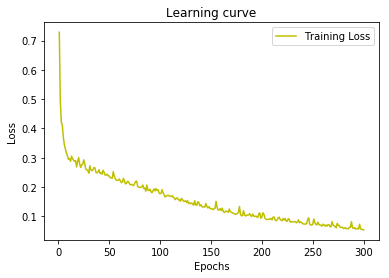

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss) + 1)
plt.plot(epochs,loss,'y',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
# plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.title('Learning curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save(model_name + '_1.h5')

In [23]:
X_test, sizes_test = get_test_data(TestPath)

In [24]:
preds_test = model.predict(X_test[1:30,:,:,:], verbose=1)

29/29 [==============================] - 3s 115ms/step


In [25]:
preds_train = model.predict(X_train[1:30,:,:,:], verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)


29/29 [==============================] - 0s 12ms/step


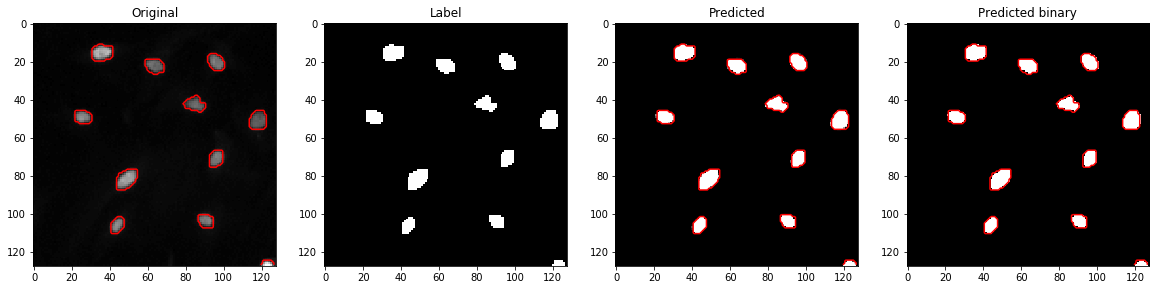

In [26]:
plot_sample(X_train[1:30,:,:,:], Y_train[1:30,:,:,:], preds_train, preds_train_t)

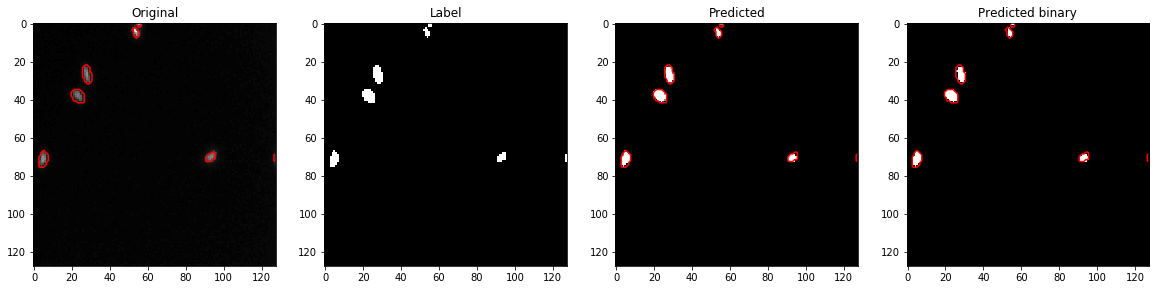

In [27]:
plot_sample(X_train[1:30,:,:,:], Y_train[1:30,:,:,:], preds_train, preds_train_t)

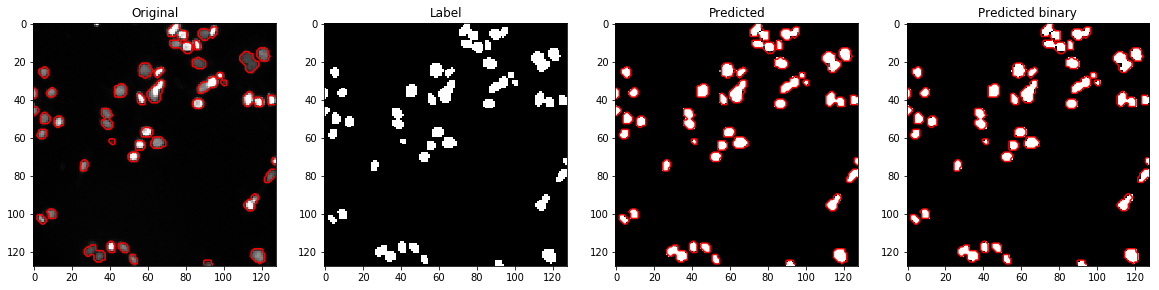

In [28]:
plot_sample(X_train[1:30,:,:,:], Y_train[1:30,:,:,:], preds_train, preds_train_t)

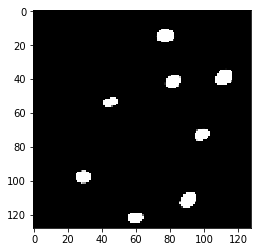

In [29]:
IM1 = preds_test[8,:,:,0]
plt.imshow(IM1,cmap='gray')
plt.show()